In [1]:
import sys
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential


2024-10-25 21:24:01.736049: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Set the path and add to sys.path
sys.path.insert(0, "/Users/jasonliu/GNN-SubNet/GNNSubNet") 

In [3]:
from GNNSubNet import GNNSubNet

/Users/jasonliu/anaconda3/lib/python3.11/site-packages/torch_geometric/typing.py:72: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/jasonliu/anaconda3/lib/python3.11/site-packages/torch_scatter/_version_cpu.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <6A7FD81D-C165-3B48-BBD3-EAC4FC9B36DD> /Users/jasonliu/anaconda3/lib/python3.11/site-packages/torch_scatter/_version_cpu.so
  Expected in:     <ED5B7495-D9A3-3875-A01B-C86976E4F5BB> /Users/jasonliu/anaconda3/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/jasonliu/anaconda3/lib/python3.11/site-packages/torch_geometric/typing.py:110: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: dlopen(/Users/jasonliu/anaconda3/lib/python3.11/site-packages/torch_sparse/_convert_cpu.so, 0x0006): Symbol not found: __ZN2at8i

In [5]:
print(dir(GNNSubNet))


['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'add_graph_attention_layer', 'download_TCGA', 'explain', 'explain_chebconv', 'explain_graphcheb', 'explain_graphcnn', 'predict', 'predict_chebconv', 'predict_graphcheb', 'predict_graphcnn', 'summary', 'train', 'train_chebconv', 'train_chebnet', 'train_graphcheb', 'train_graphcnn']


In [15]:
# Read methylation data
methy_data = pd.read_csv('/Users/jasonliu/GNN-SubNet/TCGA/KIDNEY_RANDOM_Methy_FEATURES.txt', delimiter=' ')

# Read mRNA data
mrna_data = pd.read_csv('/Users/jasonliu/GNN-SubNet/TCGA/KIDNEY_RANDOM_mRNA_FEATURES.txt', delimiter=' ')

# Read PPI data
ppi_data = pd.read_csv('/Users/jasonliu/GNN-SubNet/TCGA/KIDNEY_RANDOM_PPI.txt', delimiter=' ')

# Read target data
target_data = pd.read_csv('/Users/jasonliu/GNN-SubNet/TCGA/KIDNEY_RANDOM_TARGET.txt', delimiter=' ')

In [16]:
methy_data.head()

,ACTN1,ATP2A1,MAN1B1,NPHP4,MAEL,PROX1,NR5A2,ETV6,COL6A3,SLMAP,...,KIF18A,STX19,CSTF2T,MRC1,TRIM32,STON1,GTF3C4,OGN,ECM2,POU5F2
TCGA.3Z.A93Z,-0.0063,-0.4851,-0.4896,0.3768,0.3686,0.4394,0.3762,0.2232,0.4286,-0.2660,...,-0.3574,-0.0221,-0.2521,0.3795,-0.4882,0.2572,0.2910,0.3161,0.2704,0.0270
TCGA.6D.AA2E,0.1481,-0.4799,-0.4882,0.4153,0.3911,0.4277,0.4272,0.2435,0.3580,-0.1912,...,-0.4492,0.1014,NaN,0.4406,-0.4862,0.4077,0.3460,0.3105,0.4484,0.3682
TCGA.A3.3357,-0.0540,-0.4859,-0.4913,0.4520,0.2489,0.2177,0.4246,0.3026,0.4149,-0.2734,...,-0.3726,0.1299,-0.3404,0.3322,-0.4807,0.4417,0.4172,0.3356,0.4349,0.3700
TCGA.A3.3358,-0.1005,-0.4778,-0.4869,0.4336,0.0612,0.4032,0.4249,0.1463,0.3638,-0.2886,...,-0.4391,0.3571,-0.4185,0.4406,-0.4827,0.4041,0.0591,0.4012,0.4195,0.3517
TCGA.A3.3367,-0.0493,-0.4830,-0.4926,0.4449,0.3904,0.4525,0.4417,0.2842,0.3929,-0.3218,...,-0.4569,0.2291,-0.3374,0.4197,-0.4860,0.4455,0.1714,0.4007,0.3509,0.3725


In [17]:
mrna_data.head()

,ACTN1,ATP2A1,MAN1B1,NPHP4,MAEL,PROX1,NR5A2,ETV6,COL6A3,SLMAP,...,KIF18A,STX19,CSTF2T,MRC1,TRIM32,STON1,GTF3C4,OGN,ECM2,POU5F2
TCGA.3Z.A93Z,11.0698,3.0921,11.7421,7.8134,2.5894,1.8111,6.9463,9.1658,11.1480,9.0714,...,4.0602,0.0000,9.4688,9.4035,8.1963,8.9048,7.4951,7.3306,8.4294,0.7025
TCGA.6D.AA2E,11.4613,3.4214,10.8787,7.7058,2.2563,7.0281,3.7455,9.1420,9.5394,9.8582,...,2.0834,0.0000,9.3340,8.3859,8.5528,8.6393,7.7926,5.9026,9.1267,0.0000
TCGA.A3.3357,11.5370,3.0013,11.2569,7.9381,2.3231,2.4162,6.9123,9.7619,8.5751,9.5013,...,5.1307,1.2232,9.6955,8.5877,8.6284,10.4866,9.0014,1.4159,7.8259,0.7375
TCGA.A3.3358,12.8086,5.4678,11.3485,7.7571,6.3198,3.0558,7.9439,9.7116,10.4098,9.1938,...,5.6061,0.0000,9.4742,9.8343,8.2560,8.7421,8.5275,2.6062,8.5423,0.0000
TCGA.A3.3367,11.8861,4.9567,11.4433,8.0568,6.7388,3.7628,6.8732,9.4332,10.6955,9.2851,...,5.6191,0.9411,9.8883,10.1633,8.6338,10.3339,8.8744,3.5144,8.4985,0.0000


In [18]:
ppi_data.head()

,protein1,protein2,combined_score
4719,FUCA2,MPO,902
4721,FUCA2,HSP90B1,906
4723,FUCA2,C1GALT1,227
4725,FUCA2,GEMIN4,221
4728,FUCA2,DSN1,900


In [42]:
# Transform target data
target_t = target_data.T

target_t.columns = ['target']

target_t.head()

,target
TCGA.3Z.A93Z,1
TCGA.6D.AA2E,1
TCGA.A3.3357,1
TCGA.A3.3358,1
TCGA.A3.3367,1


In [88]:
# Remove genes containing missing values in at least one patient
methy_data_clean = methy_data.dropna(axis=1)
mrna_data_clean = mrna_data.dropna(axis=1)

# Early concatenation
merged_data = pd.concat([methy_data_clean, mrna_data_clean], axis=1)

# Check if cause NA
missing_values_per_column = merged_data.isnull().sum()

print(missing_values_per_column[missing_values_per_column > 0])


Series([], dtype: int64)


In [89]:
# Min-Max Standerdization
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(merged_data)

# Transform to DataFrame
scaled_multiomic_data = pd.DataFrame(scaled_data, index=merged_data.index, columns=merged_data.columns)

# Make sure the sample ID is consistent with the sample ID of the target data
multiomics_data = scaled_multiomic_data.loc[target_t.index]

In [64]:
# Middle Integration 
scaler = MinMaxScaler()

scaled_methy = scaler.fit_transform(methy_data_clean)
scaled_mrna = scaler.fit_transform(mrna_data_clean)

scaled_methy_df = pd.DataFrame(scaled_methy, index=methy_data_clean.index, columns=methy_data_clean.columns)
scaled_mrna_df = pd.DataFrame(scaled_mrna, index=mrna_data_clean.index, columns=mrna_data_clean.columns)

Number of components for mRNA explaining 90% variance: 168


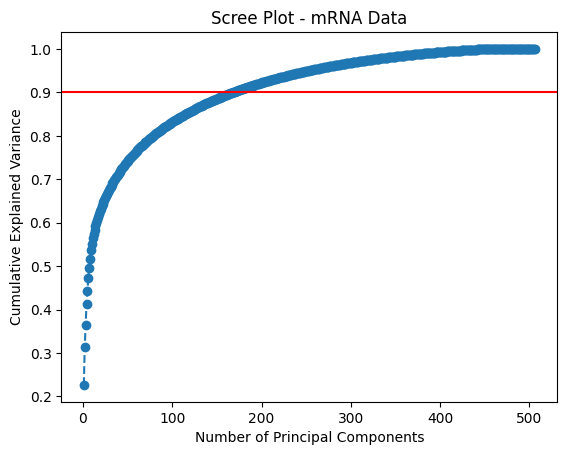

In [81]:
# Feature extraction for Middle Integration 
pca_mrna = PCA()
pca_mrna.fit(scaled_mrna_df)

explained_variance_ratio = pca_mrna.explained_variance_ratio_

cumulative_explained_variance = np.cumsum(explained_variance_ratio)

n_components_mrna = np.argmax(cumulative_explained_variance >= 0.90) + 1
print(f"Number of components for mRNA explaining 90% variance: {n_components_mrna}")

# Scree Plot mRNA
plt.plot(np.arange(1, len(explained_variance_ratio) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot - mRNA Data')
plt.axhline(y=0.90, color='r', linestyle='-')  # 90% 
plt.show()

Number of components for Methylation explaining 90% variance: 106


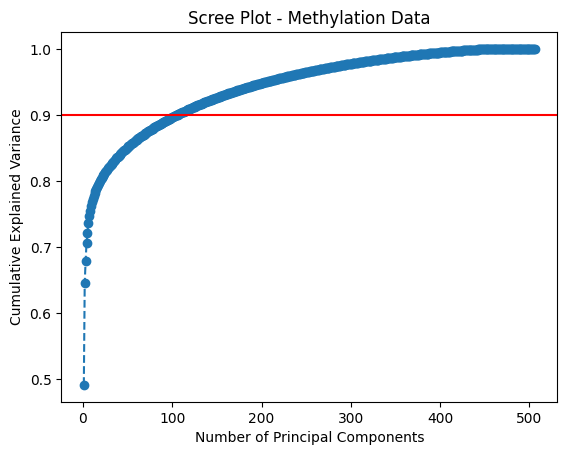

In [82]:
pca_methy = PCA()
pca_methy.fit(scaled_methy_df)

explained_variance_ratio_methy = pca_methy.explained_variance_ratio_
cumulative_explained_variance_methy = np.cumsum(explained_variance_ratio_methy)

n_components_methy = np.argmax(cumulative_explained_variance_methy >= 0.90) + 1
print(f"Number of components for Methylation explaining 90% variance: {n_components_methy}")

# Scree Plot for methylation data
plt.plot(np.arange(1, len(explained_variance_ratio_methy) + 1), cumulative_explained_variance_methy, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot - Methylation Data')
plt.axhline(y=0.90, color='r', linestyle='-')  
plt.show()

In [86]:
# Apply PCA to mRNA & methylation data
pca_mrna = PCA(n_components=n_components_mrna)
mrna_reduced = pca_mrna.fit_transform(scaled_mrna_df)

pca_methy = PCA(n_components=n_components_methy)
methy_reduced = pca_methy.fit_transform(scaled_methy_df)

print(f"Original mRNA shape: {mrna_data.shape}")
print(f"Reduced mRNA shape: {mrna_reduced.shape}")
print(f"Original Methylation shape: {methy_data.shape}")
print(f"Reduced Methylation shape: {methy_reduced.shape}")

Original mRNA shape: (506, 4785)
Reduced mRNA shape: (506, 168)
Original Methylation shape: (506, 4785)
Reduced Methylation shape: (506, 106)


In [87]:
reducted_multiomics_data = np.concatenate([mrna_reduced, methy_reduced], axis=1)

In [154]:
# Early Integration data
# Split into 80% training & 20% testing
X_train_early, X_test_early, y_train_early, y_test_early = train_test_split(multiomics_data, target_t['target'], test_size=0.2, random_state=42)

# Define stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Random Forest Model for Early Integration
rf_model_early = RandomForestClassifier(n_estimators=100, random_state=42)

# SVM model using RBF kernel for Early Integration
svm_model_early = SVC(kernel='rbf', random_state=42)

# Build the MLP model for Early Integration
mlp_model_early = Sequential()

# Input layer for Early Integration (assuming input features have the dimension X_train_early.shape[1])
mlp_model_early.add(Dense(128, input_dim=X_train_early.shape[1], activation='relu'))
# Hidden layers for Early Integration
mlp_model_early.add(Dense(64, activation='relu'))
mlp_model_early.add(Dropout(0.5))  # Add Dropout to prevent overfitting
mlp_model_early.add(Dense(32, activation='relu'))
# Output layer for Early Integration
mlp_model_early.add(Dense(1, activation='sigmoid'))

# Compile the MLP model for Early Integration
mlp_model_early.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train Models for Early Integration
rf_model_early.fit(X_train_early, y_train_early)
svm_model_early.fit(X_train_early, y_train_early)
history_early = mlp_model_early.fit(X_train_early, y_train_early, epochs=50, batch_size=32, validation_data=(X_test_early, y_test_early))

# Predict and evaluate for Early Integration
y_pred_rf_early = rf_model_early.predict(X_test_early)
accuracy_rf_early = accuracy_score(y_test_early, y_pred_rf_early)

y_pred_svm_early = svm_model_early.predict(X_test_early)
accuracy_svm_early = accuracy_score(y_test_early, y_pred_svm_early)

loss_early, accuracy_mlp_early = mlp_model_early.evaluate(X_test_early, y_test_early)


/Users/jasonliu/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6526 - loss: 0.6923 - val_accuracy: 0.9020 - val_loss: 0.3152
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8336 - loss: 0.5165 - val_accuracy: 0.9020 - val_loss: 0.2481
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8600 - loss: 0.3750 - val_accuracy: 0.9020 - val_loss: 0.2468
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8899 - loss: 0.3347 - val_accuracy: 0.9020 - val_loss: 0.2418
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8745 - loss: 0.3376 - val_accuracy: 0.9020 - val_loss: 0.2261
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8794 - loss: 0.3110 - val_accuracy: 0.9020 - val_loss: 0.2276
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8915 - loss: 0.3302 - val_accuracy: 0.9020 - val_loss: 0.2280
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8733 - loss: 0.3854 - val_accuracy: 0.9020 - val

In [107]:
# Cross-validation for Random Forest model
rf_cv_scores = cross_val_score(rf_model_early, multiomics_data, target_t['target'], cv=skf, scoring='accuracy')

# Cross-validation for SVM model
svm_cv_scores = cross_val_score(svm_model_early, multiomics_data, target_t['target'], cv=skf, scoring='accuracy')

print(f"SVM CV Accuracy: {svm_cv_scores.mean():.4f} (+/- {svm_cv_scores.std():.4f})")
print(f"Random Forest CV Accuracy: {rf_cv_scores.mean():.4f} (+/- {rf_cv_scores.std():.4f})")

SVM CV Accuracy: 0.8972 (+/- 0.0196)
Random Forest CV Accuracy: 0.8182 (+/- 0.0203)


In [148]:
# Convert the DataFrame to a NumPy array
multiomics_data_np = multiomics_data.to_numpy()

# Reshape data to match the input shape required by CNN (samples, features, channels)
X_reshaped_early = multiomics_data_np.reshape(multiomics_data.shape[0], multiomics_data.shape[1], 1)

X_train_early, X_test_early, y_train_early, y_test_early = train_test_split(X_reshaped_early, target_t['target'], test_size=0.2, random_state=42)


# Building the CNN model
cnn_model_early = Sequential()

# First convolutional layer
cnn_model_early.add(Conv1D(filters=64, kernel_size=10, activation='relu', input_shape=(X_train_early.shape[1], 1)))
cnn_model_early.add(MaxPooling1D(pool_size=2))

# Second convolutional layer
cnn_model_early.add(Conv1D(filters=64, kernel_size=7, activation='relu'))
cnn_model_early.add(MaxPooling1D(pool_size=2))

# Third convolutional layer
cnn_model_early.add(Conv1D(filters=128, kernel_size=7, activation='relu'))
cnn_model_early.add(MaxPooling1D(pool_size=2))

# Flatten layer
cnn_model_early.add(Flatten())

# Fully connected layer
cnn_model_early.add(Dense(256, activation='relu'))
cnn_model_early.add(Dropout(0.5))

# Output layer with sigmoid activation for binary classification
cnn_model_early.add(Dense(1, activation='sigmoid'))  # Use softmax activation and adjust units for multi-class problems

# Compile the model
cnn_model_early.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = cnn_model_early.fit(X_train_early, y_train_early, epochs=30, batch_size=32, validation_data=(X_test_early, y_test_early))

# Evaluate model performance
test_loss, test_accuracy_cnn_early = cnn_model_early.evaluate(X_test_early, y_test_early)
print(f'Test accuracy: {test_accuracy_cnn_early:.4f}')



/Users/jasonliu/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5751 - loss: 2.3202 - val_accuracy: 0.8922 - val_loss: 0.5403
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7506 - loss: 0.5368 - val_accuracy: 0.9020 - val_loss: 0.4064
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 933ms/step - accuracy: 0.8641 - loss: 0.3830 - val_accuracy: 0.8922 - val_loss: 0.2659
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 950ms/step - accuracy: 0.8757 - loss: 0.3714 - val_accuracy: 0.8922 - val_loss: 0.2435
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 932ms/step - accuracy: 0.9090 - loss: 0.3054 - val_accuracy: 0.9020 - val_loss: 0.2579
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 958ms/step - accuracy: 0.8817 - loss: 0.3537 - val_accuracy: 0.8922 - val_loss: 0.2406
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 892ms/step - accuracy: 0.8958 - loss: 0.3172 - val_accuracy: 0.8922 - val_loss: 0.2600
Epoch 8/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 907ms/step - accuracy: 0.8920 - loss: 0.3073 - val_accuracy: 

In [155]:
print(f"MLP (Early Integration) Accuracy: {accuracy_mlp_early:.4f}")
print(f"SVM (Early Integration) Accuracy: {accuracy_svm_early:.4f}")
print(f"RF (Early Integration) Accuracy: {accuracy_rf_early:.4f}")
print(f"CNN (Middle Integration) Accuracy:{test_accuracy_cnn_early:.4f}")

MLP (Early Integration) Accuracy: 0.9020
SVM (Early Integration) Accuracy: 0.9020
RF (Early Integration) Accuracy: 0.8235
CNN (Middle Integration) Accuracy:0.8725


In [157]:
# Middle Integration data
# Split into 80% training & 20% testing
X_train_mid, X_test_mid, y_train_mid, y_test_mid = train_test_split(reducted_multiomics_data, target_t['target'], test_size=0.2, random_state=42)

# Define stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Random Forest Model for Middle Integration
rf_model_mid = RandomForestClassifier(n_estimators=100, random_state=42)

# SVM model using RBF kernel for Middle Integration
svm_model_mid = SVC(kernel='rbf', random_state=42)

# Build the MLP model for Middle Integration
mlp_model_mid = Sequential()

# Input layer for Middle Integration (assuming input features have the dimension X_train_mid.shape[1])
mlp_model_mid.add(Dense(128, input_dim=X_train_mid.shape[1], activation='relu'))

# Hidden layers for Middle Integration
mlp_model_mid.add(Dense(64, activation='relu'))
mlp_model_mid.add(Dropout(0.5))  # Add Dropout to prevent overfitting

mlp_model_mid.add(Dense(32, activation='relu'))

# Output layer for Middle Integration
mlp_model_mid.add(Dense(1, activation='sigmoid'))

# Compile the MLP model for Middle Integration
mlp_model_mid.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train Models for Middle Integration
rf_model_mid.fit(X_train_mid, y_train_mid)
svm_model_mid.fit(X_train_mid, y_train_mid)
history_mid = mlp_model_mid.fit(X_train_mid, y_train_mid, epochs=50, batch_size=32, validation_data=(X_test_mid, y_test_mid))

# Predict and evaluate for Middle Integration
y_pred_rf_mid = rf_model_mid.predict(X_test_mid)
accuracy_rf_mid = accuracy_score(y_test_mid, y_pred_rf_mid)

y_pred_svm_mid = svm_model_mid.predict(X_test_mid)
accuracy_svm_mid = accuracy_score(y_test_mid, y_pred_svm_mid)

loss_mid, accuracy_mlp_mid = mlp_model_mid.evaluate(X_test_mid, y_test_mid)


/Users/jasonliu/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5809 - loss: 0.6041 - val_accuracy: 0.9020 - val_loss: 0.3087
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8838 - loss: 0.3464 - val_accuracy: 0.9020 - val_loss: 0.2423
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9042 - loss: 0.3148 - val_accuracy: 0.9020 - val_loss: 0.2417
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8999 - loss: 0.2934 - val_accuracy: 0.9020 - val_loss: 0.2427
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8938 - loss: 0.2944 - val_accuracy: 0.9020 - val_loss: 0.2475
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9000 - loss: 0.2656 - val_accuracy: 0.9020 - val_loss: 0.2557
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9089 - loss: 0.2551 - val_accuracy: 0.9020 - val_loss: 0.2623
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8954 - loss: 0.2363 - val_accuracy: 0.9020 - val_loss

In [151]:
# Reshape data to match the input shape required by CNN (samples, features, channels)
X_reshaped_mid = reducted_multiomics_data.reshape(reducted_multiomics_data.shape[0], reducted_multiomics_data.shape[1], 1)

X_train_mid, X_test_mid, y_train_mid, y_test_mid = train_test_split(X_reshaped_mid, target_t['target'], test_size=0.2, random_state=42)


# Building the CNN model
cnn_model_mid = Sequential()

# First convolutional layer
cnn_model_mid.add(Conv1D(filters=64, kernel_size=10, activation='relu', input_shape=(X_train_mid.shape[1], 1)))
cnn_model_mid.add(MaxPooling1D(pool_size=2))

# Second convolutional layer
cnn_model_mid.add(Conv1D(filters=64, kernel_size=7, activation='relu'))
cnn_model_mid.add(MaxPooling1D(pool_size=2))

# Third convolutional layer
cnn_model_mid.add(Conv1D(filters=128, kernel_size=7, activation='relu'))
cnn_model_mid.add(MaxPooling1D(pool_size=2))

# Flatten layer
cnn_model_mid.add(Flatten())

# Fully connected layer
cnn_model_mid.add(Dense(256, activation='relu'))
cnn_model_mid.add(Dropout(0.5))

# Output layer with sigmoid activation for binary classification
cnn_model_mid.add(Dense(1, activation='sigmoid'))  # Use softmax activation and adjust units for multi-class problems

# Compile the model
cnn_model_mid.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = cnn_model_mid.fit(X_train_mid, y_train_mid, epochs=30, batch_size=32, validation_data=(X_test_mid, y_test_mid))

# Evaluate model performance
test_loss, test_accuracy_cnn_mid = cnn_model_mid.evaluate(X_test_mid, y_test_mid)
print(f'Test accuracy: {test_accuracy_cnn_mid:.4f}')


Epoch 1/30


/Users/jasonliu/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.7754 - loss: 0.5072 - val_accuracy: 0.8824 - val_loss: 0.2760
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9015 - loss: 0.3221 - val_accuracy: 0.9020 - val_loss: 0.2296
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9048 - loss: 0.2769 - val_accuracy: 0.9020 - val_loss: 0.2200
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8954 - loss: 0.2737 - val_accuracy: 0.8922 - val_loss: 0.2224
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9029 - loss: 0.2513 - val_accuracy: 0.8922 - val_loss: 0.2264
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9029 - loss: 0.2365 - val_accuracy: 0.8922 - val_loss: 0.2372
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8750 - loss: 0.2727 - val_accuracy: 0.9020 - val_loss: 0.2701
Epoch 8/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8986 - loss: 0.2407 - val_accuracy: 0.8824 - val_loss: 0.

In [152]:
print(f"MLP (Middle Integration) Accuracy: {accuracy_mlp_mid:.4f}")
print(f"SVM (Middle Integration) Accuracy: {accuracy_svm_mid:.4f}")
print(f"RF (Middle Integration) Accuracy: {accuracy_rf_mid:.4f}")
print(f"CNN (Middle Integration) Accuracy: {test_accuracy_cnn_mid:.4f}")

MLP (Middle Integration) Accuracy: 0.8137
SVM (Middle Integration) Accuracy: 0.9020
RF (Middle Integration) Accuracy: 0.8137
CNN (Middle Integration) Accuracy: 0.8235


In [112]:
# Cross-validation for Random Forest model
rf_cv_scores = cross_val_score(rf_model_mid, reducted_multiomics_data, target_t['target'], cv=skf, scoring='accuracy')

# Cross-validation for SVM model
svm_cv_scores = cross_val_score(svm_model_mid, reducted_multiomics_data, target_t['target'], cv=skf, scoring='accuracy')

print(f"SVM CV Accuracy: {svm_cv_scores.mean():.4f} (+/- {svm_cv_scores.std():.4f})")
print(f"Random Forest CV Accuracy: {rf_cv_scores.mean():.4f} (+/- {rf_cv_scores.std():.4f})")

SVM CV Accuracy: 0.8972 (+/- 0.0196)
Random Forest CV Accuracy: 0.8043 (+/- 0.0192)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


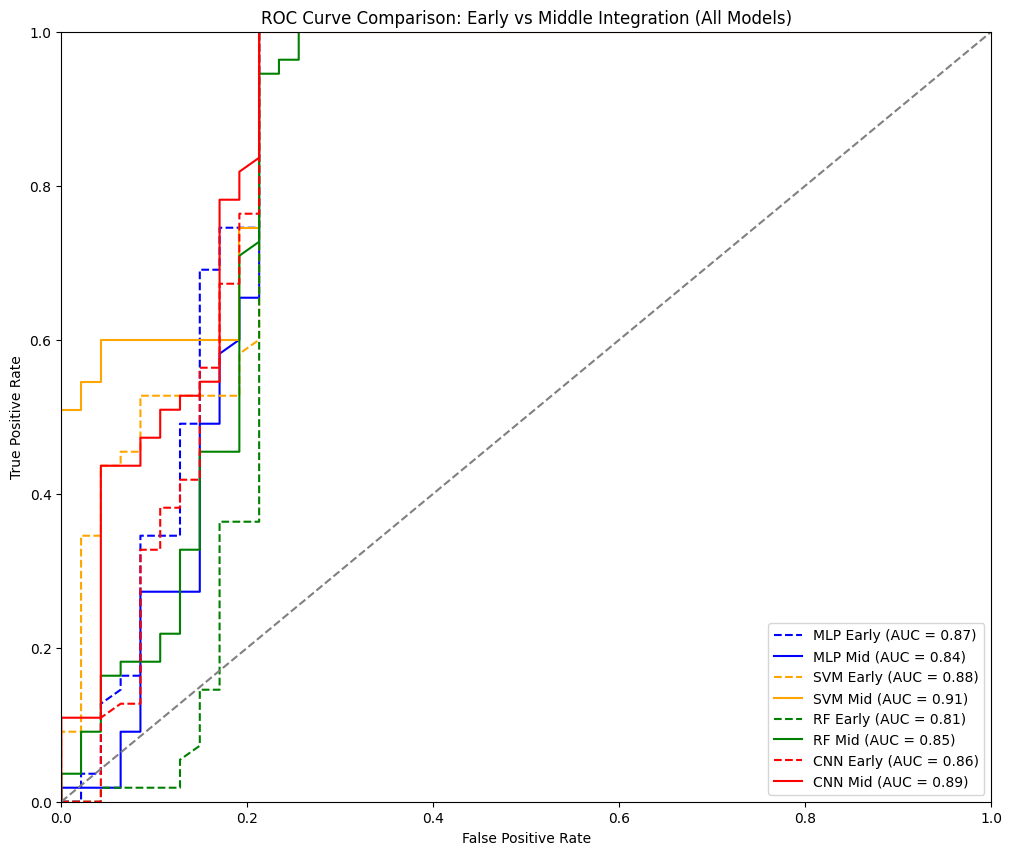

In [158]:
# y_true should be your test set labels, like y_test_early and y_test_mid
y_true_early = y_test_early  # True labels for early integration
y_true_mid = y_test_mid      # True labels for middle integration

# Predicted probabilities for each model
y_pred_mlp_early = mlp_model_early.predict(X_test_early).ravel()  
y_pred_svm_early = svm_model_early.decision_function(X_test_early)  # SVM uses decision_function
y_pred_rf_early = rf_model_early.predict_proba(X_test_early)[:, 1]
y_pred_cnn_early = cnn_model_early.predict(X_test_early).ravel()  # CNN output needs to be flattened

y_pred_mlp_mid = mlp_model_mid.predict(X_test_mid).ravel()
y_pred_svm_mid = svm_model_mid.decision_function(X_test_mid)
y_pred_rf_mid = rf_model_mid.predict_proba(X_test_mid)[:, 1]
y_pred_cnn_mid = cnn_model_mid.predict(X_test_mid).ravel()

# Plot ROC curves
plt.figure(figsize=(12, 10))

# MLP ROC curve
fpr_mlp_early, tpr_mlp_early, _ = roc_curve(y_true_early, y_pred_mlp_early)
fpr_mlp_mid, tpr_mlp_mid, _ = roc_curve(y_true_mid, y_pred_mlp_mid)
roc_auc_mlp_early = auc(fpr_mlp_early, tpr_mlp_early)
roc_auc_mlp_mid = auc(fpr_mlp_mid, tpr_mlp_mid)
plt.plot(fpr_mlp_early, tpr_mlp_early, color='blue', linestyle='--', label=f'MLP Early (AUC = {roc_auc_mlp_early:.2f})')
plt.plot(fpr_mlp_mid, tpr_mlp_mid, color='blue', label=f'MLP Mid (AUC = {roc_auc_mlp_mid:.2f})')

# SVM ROC curve
fpr_svm_early, tpr_svm_early, _ = roc_curve(y_true_early, y_pred_svm_early)
fpr_svm_mid, tpr_svm_mid, _ = roc_curve(y_true_mid, y_pred_svm_mid)
roc_auc_svm_early = auc(fpr_svm_early, tpr_svm_early)
roc_auc_svm_mid = auc(fpr_svm_mid, tpr_svm_mid)
plt.plot(fpr_svm_early, tpr_svm_early, color='orange', linestyle='--', label=f'SVM Early (AUC = {roc_auc_svm_early:.2f})')
plt.plot(fpr_svm_mid, tpr_svm_mid, color='orange', label=f'SVM Mid (AUC = {roc_auc_svm_mid:.2f})')

# Random Forest ROC curve
fpr_rf_early, tpr_rf_early, _ = roc_curve(y_true_early, y_pred_rf_early)
fpr_rf_mid, tpr_rf_mid, _ = roc_curve(y_true_mid, y_pred_rf_mid)
roc_auc_rf_early = auc(fpr_rf_early, tpr_rf_early)
roc_auc_rf_mid = auc(fpr_rf_mid, tpr_rf_mid)
plt.plot(fpr_rf_early, tpr_rf_early, color='green', linestyle='--', label=f'RF Early (AUC = {roc_auc_rf_early:.2f})')
plt.plot(fpr_rf_mid, tpr_rf_mid, color='green', label=f'RF Mid (AUC = {roc_auc_rf_mid:.2f})')

# CNN ROC curve
fpr_cnn_early, tpr_cnn_early, _ = roc_curve(y_true_early, y_pred_cnn_early)
fpr_cnn_mid, tpr_cnn_mid, _ = roc_curve(y_true_mid, y_pred_cnn_mid)
roc_auc_cnn_early = auc(fpr_cnn_early, tpr_cnn_early)
roc_auc_cnn_mid = auc(fpr_cnn_mid, tpr_cnn_mid)
plt.plot(fpr_cnn_early, tpr_cnn_early, color='red', linestyle='--', label=f'CNN Early (AUC = {roc_auc_cnn_early:.2f})')
plt.plot(fpr_cnn_mid, tpr_cnn_mid, color='red', label=f'CNN Mid (AUC = {roc_auc_cnn_mid:.2f})')

# Plot the diagonal line (baseline)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Set axis limits and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison: Early vs Middle Integration (All Models)')
plt.legend(loc='lower right')

# Display the plot
plt.show()


In [113]:
# Early Integration predictions
y_pred_rf_early = rf_model_early.predict(X_test_early)
y_pred_svm_early = svm_model_early.predict(X_test_early)
y_pred_mlp_early = mlp_model_early.predict(X_test_early)
y_pred_mlp_early = (y_pred_mlp_early > 0.5).astype(int)

# Middle Integration predictions
y_pred_rf_mid = rf_model_mid.predict(X_test_mid)
y_pred_svm_mid = svm_model_mid.predict(X_test_mid)
y_pred_mlp_mid = mlp_model_mid.predict(X_test_mid)
y_pred_mlp_mid = (y_pred_mlp_mid > 0.5).astype(int)

# F1 scores for Early Integration
f1_rf_early = f1_score(y_test_early, y_pred_rf_early, average='weighted')
f1_svm_early = f1_score(y_test_early, y_pred_svm_early, average='weighted')
f1_mlp_early = f1_score(y_test_early, y_pred_mlp_early, average='weighted')

# F1 scores for Middle Integration
f1_rf_mid = f1_score(y_test_mid, y_pred_rf_mid, average='weighted')
f1_svm_mid = f1_score(y_test_mid, y_pred_svm_mid, average='weighted')
f1_mlp_mid = f1_score(y_test_mid, y_pred_mlp_mid, average='weighted')

# Print F1 scores for comparison
print(f"F1 Score (Random Forest, Early Integration): {f1_rf_early:.4f}")
print(f"F1 Score (SVM, Early Integration): {f1_svm_early:.4f}")
print(f"F1 Score (MLP, Early Integration): {f1_mlp_early:.4f}")
print(f"F1 Score (Random Forest, Middle Integration): {f1_rf_mid:.4f}")
print(f"F1 Score (SVM, Middle Integration): {f1_svm_mid:.4f}")
print(f"F1 Score (MLP, Middle Integration): {f1_mlp_mid:.4f}")


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x170542a20> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
F1 Score (Random Forest, Early Integration): 0.8232
F1 Score (SVM, Early Integration): 0.9002
F1 Score (MLP, Early Integration): 0.7943
F1 Score (Random Forest, Middle

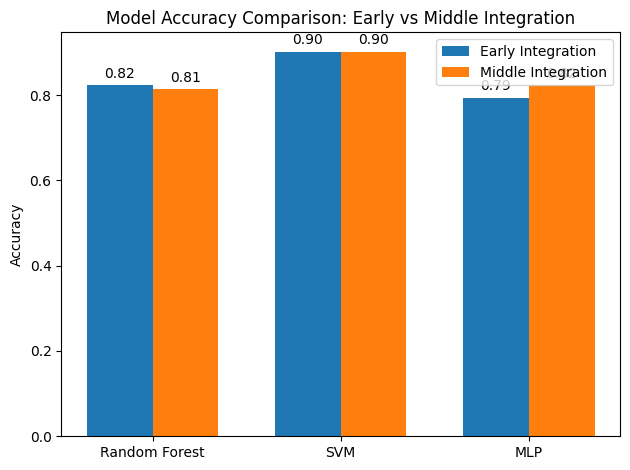

In [114]:
# Create lists for the accuracies of the different models
accuracy_early = [accuracy_rf_early, accuracy_svm_early, accuracy_mlp_early]
accuracy_mid = [accuracy_rf_mid, accuracy_svm_mid, accuracy_mlp_mid]

# Labels for the models
labels = ['Random Forest', 'SVM', 'MLP']

# Set up the figure and axes
x = np.arange(len(labels))  # The label locations
width = 0.35  # The width of the bars

fig, ax = plt.subplots()

# Plot the bars for early integration
rects1 = ax.bar(x - width/2, accuracy_early, width, label='Early Integration')

# Plot the bars for middle integration
rects2 = ax.bar(x + width/2, accuracy_mid, width, label='Middle Integration')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Model Accuracy Comparison: Early vs Middle Integration')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Function to add labels on top of the bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Add labels on top of the bars
add_labels(rects1)
add_labels(rects2)

# Adjust layout to make room for the labels
fig.tight_layout()

# Show the plot
plt.show()


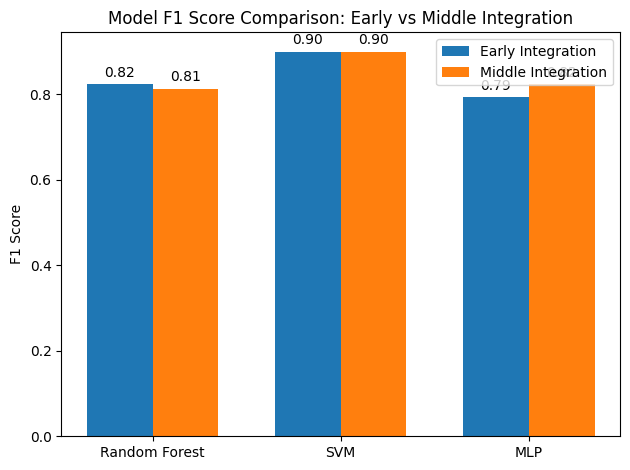

In [115]:
# Create lists for the F1 scores of the different models
f1_early = [f1_rf_early, f1_svm_early, f1_mlp_early]
f1_mid = [f1_rf_mid, f1_svm_mid, f1_mlp_mid]

# Set up the figure and axes for F1 comparison
fig, ax = plt.subplots()

# Plot the bars for early integration F1 scores
rects1 = ax.bar(x - width/2, f1_early, width, label='Early Integration')

# Plot the bars for middle integration F1 scores
rects2 = ax.bar(x + width/2, f1_mid, width, label='Middle Integration')

# Add labels, title and x-axis tick labels
ax.set_ylabel('F1 Score')
ax.set_title('Model F1 Score Comparison: Early vs Middle Integration')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add F1 score labels on top of the bars
add_labels(rects1)
add_labels(rects2)

# Adjust layout and show plot
fig.tight_layout()
plt.show()


In [6]:
loc   = "/Users/jasonliu/GNN-SubNet/TCGA"
# PPI network
ppi   = f'{loc}/KIDNEY_RANDOM_PPI.txt'
# single-omic features
#feats = [f'{loc}/KIDNEY_RANDOM_Methy_FEATURES.txt']
# multi-omic features
feats = [f'{loc}/KIDNEY_RANDOM_mRNA_FEATURES.txt', f'{loc}/KIDNEY_RANDOM_Methy_FEATURES.txt']
# outcome class
targ  = f'{loc}/KIDNEY_RANDOM_TARGET.txt'

# Load the multi-omics data 
g = GNNSubNet(loc, ppi, feats, targ, random_seed=42)

# Train the GNN classifier and validate performance on a test set
g.train()

Graph is connected  False
Calculate subgraph ...
Number of subgraphs:  118
Size of subgraph:  2049
Graph is connected  True
##################
# DATASET LOADED #
##################
graphcnn for training ...
Graphs class 0: 200, Graphs class 1: 306
Length of balanced dataset list: 400
Train graph class 0: 164, train graph class 1: 156
Validation graph class 0: 36, validation graph class 1: 44


  0%|          | 0/35 [00:00<?, ?batch/s]/Users/jasonliu/GNN-SubNet/GNNSubNet/graphcnn.py:134: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:620.)
  graph_pool = torch.sparse.FloatTensor(idx, elem, torch.Size([len(batch_graph), start_idx[-1]]))
100%|██████████| 35/35 [00:06<00:00,  5.07batch/s]


Epoch 0, loss 230.5337
Train Acc 0.5406
Epoch 0, val_loss 44.7451
Saving best model with validation loss 44.74506759643555


100%|██████████| 35/35 [00:06<00:00,  5.47batch/s]


Epoch 1, loss 34.7142
Train Acc 0.7094
Epoch 1, val_loss 11.7116
Saving best model with validation loss 11.711624145507812


100%|██████████| 35/35 [00:07<00:00,  4.80batch/s]


Epoch 2, loss 22.7601
Train Acc 0.5813
Epoch 2, val_loss 9.3140
Saving best model with validation loss 9.314026832580566


100%|██████████| 35/35 [00:06<00:00,  5.16batch/s]


Epoch 3, loss 21.4338
Train Acc 0.7219
Epoch 3, val_loss 10.5781


100%|██████████| 35/35 [00:08<00:00,  4.24batch/s]


Epoch 4, loss 26.1612
Train Acc 0.5125
Epoch 4, val_loss 89.0255


100%|██████████| 35/35 [00:05<00:00,  6.12batch/s]


Epoch 5, loss 19.4390
Train Acc 0.8125
Epoch 5, val_loss 4.6878
Saving best model with validation loss 4.687828540802002


100%|██████████| 35/35 [00:06<00:00,  5.25batch/s]


Epoch 6, loss 14.0458
Train Acc 0.7188
Epoch 6, val_loss 7.4858


100%|██████████| 35/35 [00:05<00:00,  5.87batch/s]


Epoch 7, loss 21.3571
Train Acc 0.5406
Epoch 7, val_loss 16.1917


100%|██████████| 35/35 [00:05<00:00,  6.37batch/s]


Epoch 8, loss 16.8927
Train Acc 0.7688
Epoch 8, val_loss 7.9263


100%|██████████| 35/35 [00:06<00:00,  5.70batch/s]


Epoch 9, loss 18.1447
Train Acc 0.7188
Epoch 9, val_loss 6.6462


100%|██████████| 35/35 [00:06<00:00,  5.75batch/s]


Epoch 10, loss 10.7640
Train Acc 0.7594
Epoch 10, val_loss 4.0606
Saving best model with validation loss 4.060608863830566


100%|██████████| 35/35 [00:06<00:00,  5.68batch/s]


Epoch 11, loss 10.2801
Train Acc 0.5813
Epoch 11, val_loss 7.1258


100%|██████████| 35/35 [00:06<00:00,  5.73batch/s]


Epoch 12, loss 9.0304
Train Acc 0.5875
Epoch 12, val_loss 6.4005


100%|██████████| 35/35 [00:06<00:00,  5.15batch/s]


Epoch 13, loss 10.5649
Train Acc 0.4969
Epoch 13, val_loss 16.4008


100%|██████████| 35/35 [00:06<00:00,  5.05batch/s]


Epoch 14, loss 17.3929
Train Acc 0.7094
Epoch 14, val_loss 3.8763
Saving best model with validation loss 3.8763251304626465


100%|██████████| 35/35 [00:06<00:00,  5.26batch/s]


Epoch 15, loss 7.7864
Train Acc 0.8187
Epoch 15, val_loss 3.1273
Saving best model with validation loss 3.127290964126587


100%|██████████| 35/35 [00:05<00:00,  6.54batch/s]


Epoch 16, loss 8.5635
Train Acc 0.6188
Epoch 16, val_loss 4.7846


100%|██████████| 35/35 [00:05<00:00,  6.33batch/s]


Epoch 17, loss 8.1738
Train Acc 0.6188
Epoch 17, val_loss 4.7466


100%|██████████| 35/35 [00:05<00:00,  6.23batch/s]


Epoch 18, loss 6.6522
Train Acc 0.8219
Epoch 18, val_loss 3.3936


100%|██████████| 35/35 [00:06<00:00,  5.25batch/s]


Epoch 19, loss 7.2444
Train Acc 0.6906
Epoch 19, val_loss 3.7194

Confusion matrix (Validation set):

[[27  9]
 [ 3 41]]
Validation accuracy: 85.0%
Validation loss 3.127290964126587


In [9]:
# Run the Explainer with 10 iterations
g.explain(10)


------- Run the Explainer -------

Explainer::Iteration 1 of 10
Explainer::Iteration 2 of 10
Explainer::Iteration 3 of 10
Explainer::Iteration 4 of 10
Explainer::Iteration 5 of 10
Explainer::Iteration 6 of 10
Explainer::Iteration 7 of 10
Explainer::Iteration 8 of 10
Explainer::Iteration 9 of 10
Explainer::Iteration 10 of 10


In [14]:
# Edge and Node (Gene) Importances 
print(g.gene_names)
print(g.edges)

['A2M' 'AACS' 'AARS' ... 'ZNRF3' 'ZRANB1' 'ZWILCH']
[[   0  124]
 [   0  128]
 [   0  355]
 ...
 [2048 1207]
 [2048 1281]
 [2048 1688]]


In [15]:
# Importances
print(g.edge_mask)
print(g.node_mask)

[[0.4436892 ]
 [0.83189076]
 [0.83072567]
 ...
 [0.72481537]
 [0.2775697 ]
 [0.27179712]]
[0.77674353 0.31658074 0.08502478 ... 0.7459034  0.48772088 0.4451739 ]


In [17]:
# Detected modules and their importances
print(g.modules)
print(g.modules[0])
print(g.module_importances)

Clustering with 2049 elements and 39 clusters
[ 0] 0, 16, 17, 45, 46, 47, 49, 50, 61, 62, 69, 70, 71, 100, 101, 123, 124,
     125, 126, 127, 128, 189, 198, 226, 227, 229, 230, 231, 232, 233, 234,
     235, 236, 237, 270, 280, 290, 291, 295, 297, 301, 334, 355, 374, 375,
     388, 391, 392, 396, 397, 398, 405, 406, 407, 408, 418, 422, 429, 507,
     521, 535, 570, 614, 615, 619, 620, 650, 656, 663, 668, 676, 685, 722,
     731, 733, 734, 742, 745, 746, 747, 755, 797, 833, 834, 835, 845, 914,
     915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928,
     929, 930, 931, 932, 933, 934, 953, 995, 1004, 1005, 1006, 1007, 1008,
     1009, 1010, 1011, 1012, 1013, 1014, 1018, 1039, 1042, 1043, 1046, 1049,
     1077, 1082, 1110, 1126, 1127, 1129, 1133, 1152, 1159, 1191, 1208, 1227,
     1228, 1255, 1261, 1303, 1304, 1346, 1397, 1398, 1421, 1434, 1464, 1481,
     1482, 1562, 1563, 1611, 1635, 1651, 1660, 1665, 1666, 1667, 1668, 1669,
     1686, 1694, 1733, 1734, 1737, 1739, 1745